# PHD Hackathon

# `Broadband Outage Detection`

### Description:

India is seeing an explosion of new competitors in the Broadband space. 'India Broadband' is
a company that is now seeing a lot of customer churn due to customer dissatisfaction
because of broadband outages.

The company has now curated a dataset, where it tracks several variables that it believes
impact the `outage_duration`. They have tracked three different outage durations, `0` for
no outage, `1` for short outages that last anywhere between a few minutes and a maximum
of 2 hours, and `2` for long outages that can last from 2 hours to sometimes even a couple
of days.

You will now have to use these metrics that the company has tracked to create a machine
learning model that will be able to predict the `outage_duration` so that the company can
better handle outages and improve customer satisfaction and therefore reduce customer
churn.


## 1. Importing Libraries

In [99]:
import numpy as np                   # array/mathematical package
import pandas as pd                  # data manipulation/analysis package
import matplotlib.pyplot as plt      # library for vizualisations in matlab style
import seaborn as sns                # matplot based package for stylised plots
sns.set()                            # set seaborn as default aesthetics in plots
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

## 2 Reading Datasets

In [100]:
# broadband data
broadband_df = pd.read_csv('data/broadband_data.csv')

# outage data
outage_df = pd.read_csv('data/outage_data.csv')

# report data
report_df = pd.read_csv('data/report_data.csv')

# server data
server_df = pd.read_csv('data/server_data.csv')

# train data
train_df = pd.read_csv('data/train_data.csv')

## 3. Exploring the datasets

#### 3.1 Broadband data

In [101]:
broadband_df.head()

,id,broadband_type
0,6597,broadband_type_8
1,8011,broadband_type_8
2,2597,broadband_type_8
3,5022,broadband_type_8
4,6852,broadband_type_8


In [102]:
# creating a dictionary for broadband types with key as the type and name as the value
broadband_type_dict = {  'broadband_type_8'  : 'ADSL 1',
                         'broadband_type_2'  : 'ADSL 2',
                         'broadband_type_6'  : 'ADSL 2+',
                         'broadband_type_7'  : 'Cable',
                         'broadband_type_4'  : 'Fiber 1',
                         'broadband_type_9'  : 'BPL',
                         'broadband_type_3'  : 'Fiber 2',
                         'broadband_type_10' : 'Fiber High Speed',
                         'broadband_type_1'  : 'Fiber Ultra',
                         'broadband_type_5'  : 'Fiber Ultra Max'}


In [103]:
# mapping the values of the dictionary broadband_type_dict based on the broadband_name as the key
broadband_df['broadband_name']=broadband_df.broadband_type.map(broadband_type_dict)

In [104]:
broadband_df.head()

,id,broadband_type,broadband_name
0,6597,broadband_type_8,ADSL 1
1,8011,broadband_type_8,ADSL 1
2,2597,broadband_type_8,ADSL 1
3,5022,broadband_type_8,ADSL 1
4,6852,broadband_type_8,ADSL 1


In [105]:
broadband_df.tail()

,id,broadband_type,broadband_name
21071,3761,broadband_type_8,ADSL 1
21072,8720,broadband_type_8,ADSL 1
21073,6488,broadband_type_8,ADSL 1
21074,878,broadband_type_8,ADSL 1
21075,4464,broadband_type_8,ADSL 1


In [106]:
# shape of the data post mapping with the dictionary
broadband_df.shape

(21076, 3)

In [107]:
# description of the data
broadband_df.describe(include='all')

,id,broadband_type,broadband_name
count,21076.000000,21076,21076
unique,NaN,10,10
top,NaN,broadband_type_8,ADSL 1
freq,NaN,10268,10268
mean,9255.869330,NaN,NaN
std,5366.730222,NaN,NaN
min,1.000000,NaN,NaN
25%,4599.750000,NaN,NaN
50%,9256.500000,NaN,NaN
75%,13907.250000,NaN,NaN


In [108]:
# summary of the dataframe
broadband_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21076 entries, 0 to 21075
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              21076 non-null  int64 
 1   broadband_type  21076 non-null  object
 2   broadband_name  21076 non-null  object
dtypes: int64(1), object(2)
memory usage: 494.1+ KB


>Seems like id is being treated as int, i.e. as numerical but as we know it is a category and so are the other two columns. Hence changing the datatype in the next step

In [109]:
broadband_df = broadband_df.astype('category')
broadband_df.head()

,id,broadband_type,broadband_name
0,6597,broadband_type_8,ADSL 1
1,8011,broadband_type_8,ADSL 1
2,2597,broadband_type_8,ADSL 1
3,5022,broadband_type_8,ADSL 1
4,6852,broadband_type_8,ADSL 1


In [110]:
broadband_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21076 entries, 0 to 21075
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              21076 non-null  category
 1   broadband_type  21076 non-null  category
 2   broadband_name  21076 non-null  category
dtypes: category(3)
memory usage: 868.2 KB


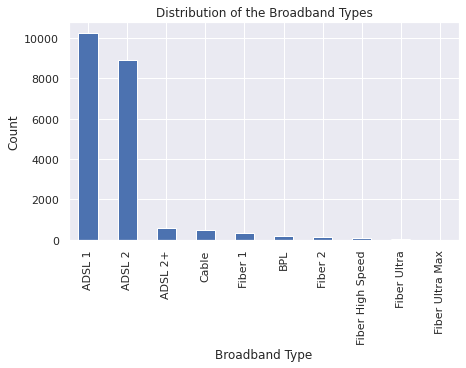

In [111]:
plt.figure(figsize=(7,4))
broadband_df.broadband_name.value_counts().plot(kind='bar')
plt.xlabel('Broadband Type')
plt.ylabel('Count')
plt.title('Distribution of the Broadband Types')
plt.show()

> On exploring the data set we find that the broadband company has recorded most of the complaints where the broadband type was Either ADSL 1 or ADSL 2 where the Fiber type of broadbands have registered the least complaints

`Wrangling of data for model building`

In [112]:
# transforming the categorical columns to numerical as needed for the model building
broadband_df = broadband_df[['id','broadband_name']].pivot_table(values='broadband_name',index='id',columns='broadband_name',fill_value=0,aggfunc=len)
broadband_df.head()

broadband_name,ADSL 1,ADSL 2,ADSL 2+,BPL,Cable,Fiber 1,Fiber 2,Fiber High Speed,Fiber Ultra,Fiber Ultra Max
id,,,,,,,,,,
1,1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0


In [113]:
broadband_df.columns = broadband_df.columns.categories
broadband_df.head()

,ADSL 1,ADSL 2,ADSL 2+,BPL,Cable,Fiber 1,Fiber 2,Fiber High Speed,Fiber Ultra,Fiber Ultra Max
id,,,,,,,,,,
1,1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0


In [114]:
broadband_df.reset_index(inplace=True)
broadband_df.head()

,id,ADSL 1,ADSL 2,ADSL 2+,BPL,Cable,Fiber 1,Fiber 2,Fiber High Speed,Fiber Ultra,Fiber Ultra Max
0,1,1,0,1,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0,0
3,4,0,1,0,0,0,0,0,0,0,0
4,5,0,1,0,0,0,0,0,0,0,0


In [115]:
# Checking for nulls in the data
broadband_df.isnull().values.any()

False

In [116]:
broadband_df.shape

(18552, 11)

#### 3.2 Outage data

In [117]:
outage_df.head()

,id,outage_type
0,6597,outage_type_2
1,8011,outage_type_2
2,2597,outage_type_2
3,5022,outage_type_1
4,6852,outage_type_1


In [118]:
# shape of the data
outage_df.shape

(18552, 2)

In [119]:
# summary of the dataset
outage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18552 entries, 0 to 18551
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           18552 non-null  int64 
 1   outage_type  18552 non-null  object
dtypes: int64(1), object(1)
memory usage: 290.0+ KB


>Seems like id is being treated as int, i.e. as numerical but as we know it is a category and so are the other two columns. Hence changing the datatype in the next step

In [120]:
# changing the data type of the columns
outage_df = outage_df.astype('category')

In [121]:
# description of the data
outage_df.describe(include='all')

,id,outage_type
count,18552,18552
unique,18552,5
top,18552,outage_type_2
freq,1,8737


Above cell indicates
1. All the ids are unique
2. Most frequent outage type is `outage_type_2` which has occurred `8737` times

In [122]:
# The frequency of each outage type
outage_df.outage_type.value_counts()

outage_type_2    8737
outage_type_1    8728
outage_type_4    1014
outage_type_5      65
outage_type_3       8
Name: outage_type, dtype: int64

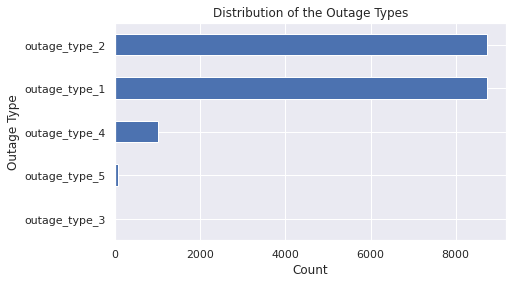

In [123]:
# Plotting the frequency from the above cell
plt.figure(figsize=(7,4))
outage_df.outage_type.value_counts(ascending=True).plot(kind='barh')
plt.ylabel('Outage Type')
plt.xlabel('Count')
plt.title('Distribution of the Outage Types')
plt.show()

> `outage_type_1` and `outage_type_2` seems to be most frequent whereas `outage_type_5` and `outage_type_3` are the least

`Wrangling the data for model building`

In [124]:
outage_df = outage_df.pivot_table(values='outage_type',index='id',columns='outage_type',fill_value=0,aggfunc=len)
outage_df.head()

outage_type,outage_type_1,outage_type_2,outage_type_3,outage_type_4,outage_type_5
id,,,,,
1,1,0,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,0,1,0
5,0,1,0,0,0


In [125]:
outage_df.columns = outage_df.columns.categories
outage_df.head()

,outage_type_1,outage_type_2,outage_type_3,outage_type_4,outage_type_5
id,,,,,
1,1,0,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,0,1,0
5,0,1,0,0,0


In [126]:
outage_df.reset_index(inplace=True)
outage_df.head()

,id,outage_type_1,outage_type_2,outage_type_3,outage_type_4,outage_type_5
0,1,1,0,0,0,0
1,2,0,1,0,0,0
2,3,1,0,0,0,0
3,4,0,0,0,1,0
4,5,0,1,0,0,0


In [127]:
# Checking for any nulls
outage_df.isnull().values.any()

False

In [128]:
# Final shape after processing
outage_df.shape

(18552, 6)

#### 3.3 Report data

In [129]:
#Initial shape of the data
report_df.shape

(58671, 3)

In [130]:
# Summary of the data
report_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58671 entries, 0 to 58670
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               58671 non-null  int64 
 1   log_report_type  58671 non-null  object
 2   volume           58671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


> `id` and `log_report_type` are of type category but it is currently of type int64 and object respectively.

In [131]:
# Changing the data type of the columns mention above
report_df[['id','log_report_type']] = report_df[['id','log_report_type']].astype('category')

In [132]:
report_df.describe(include='all')

,id,log_report_type,volume
count,58671.0,58671,58671.000000
unique,18552.0,386,NaN
top,15184.0,log_report_type_312,NaN
freq,20.0,5267,NaN
mean,NaN,NaN,9.685296
std,NaN,NaN,27.314433
min,NaN,NaN,1.000000
25%,NaN,NaN,1.000000
50%,NaN,NaN,2.000000
75%,NaN,NaN,7.000000


From the above description we can infer that
1. `id` is not unique, which means an `id` has occured multiple times and with possibly different log_report_type
3. Total report types are 386
2. Most frequent `log_report_type` is `log_report_type_312` which has occured `5267` times

**Since there are a total of 386 unique reports it will be difficult to visualize all 386 in a single frame, hence lets see what are the top 20 most frequent log_report_type**

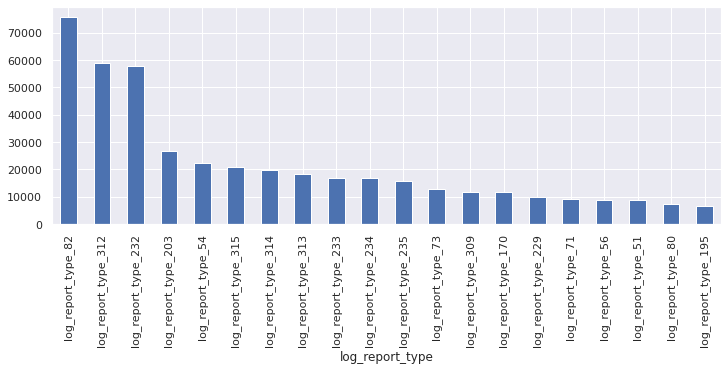

In [133]:
plt.figure(figsize=(12,4))
report_df.groupby('log_report_type')['volume'].sum().nlargest(20).plot(kind='bar')
plt.show()

**Now lets see what are the ids that registered most complaints, by visualizing the 50 most frequent ids and their frequencies**

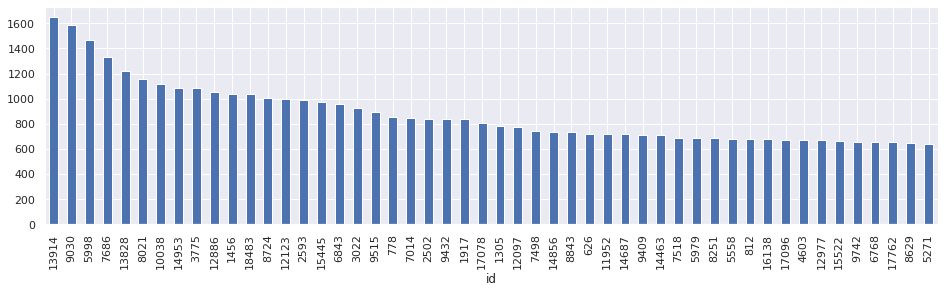

In [134]:
plt.figure(figsize=(16,4))
report_df.groupby('id')['volume'].sum().nlargest(50).plot(kind='bar')
plt.show()

`Wrangling data for model building`

In [135]:
report_volume_df = pd.DataFrame(report_df.groupby('id')['volume'].sum()).reset_index()
report_volume_df.rename(columns={'volume':'report_volume'})
report_volume_df.head()

,id,volume
0,1,5
1,2,5
2,3,2
3,4,3
4,5,17


In [136]:
report_volume_df

,id,volume
0,1,5
1,2,5
2,3,2
3,4,3
4,5,17
...,...,...
18547,18548,22
18548,18549,8
18549,18550,6
18550,18551,7


In [137]:
report_df = report_df.pivot_table(values='volume',index='id',columns='log_report_type',fill_value=0,aggfunc=np.sum)
report_df.head()

log_report_type,log_report_type_1,log_report_type_10,log_report_type_100,log_report_type_101,log_report_type_102,log_report_type_103,log_report_type_104,log_report_type_105,log_report_type_106,log_report_type_107,log_report_type_108,log_report_type_109,log_report_type_11,log_report_type_110,log_report_type_111,log_report_type_112,log_report_type_113,log_report_type_114,log_report_type_115,log_report_type_116,log_report_type_117,log_report_type_118,log_report_type_119,log_report_type_12,log_report_type_120,log_report_type_121,log_report_type_122,log_report_type_123,log_report_type_124,log_report_type_125,log_report_type_126,log_report_type_127,log_report_type_128,log_report_type_129,log_report_type_13,log_report_type_130,log_report_type_131,log_report_type_132,log_report_type_133,log_report_type_134,...,log_report_type_63,log_report_type_64,log_report_type_65,log_report_type_66,log_report_type_67,log_report_type_68,log_report_type_69,log_report_type_7,log_report_type_70,log_report_type_71,log_report_type_72,log_report_type_73,log_report_type_74,log_report_type_75,log_report_type_76,log_report_type_77,log_report_type_78,log_report_type_79,log_report_type_8,log_report_type_80,log_report_type_81,log_report_type_82,log_report_type_83,log_report_type_84,log_report_type_85,log_report_type_86,log_report_type_87,log_report_type_88,log_report_type_89,log_report_type_9,log_report_type_90,log_report_type_91,log_report_type_92,log_report_type_93,log_report_type_94,log_report_type_95,log_report_type_96,log_report_type_97,log_report_type_98,log_report_type_99
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [138]:
report_df.columns = report_df.columns.categories
report_df.head()

,log_report_type_1,log_report_type_10,log_report_type_100,log_report_type_101,log_report_type_102,log_report_type_103,log_report_type_104,log_report_type_105,log_report_type_106,log_report_type_107,log_report_type_108,log_report_type_109,log_report_type_11,log_report_type_110,log_report_type_111,log_report_type_112,log_report_type_113,log_report_type_114,log_report_type_115,log_report_type_116,log_report_type_117,log_report_type_118,log_report_type_119,log_report_type_12,log_report_type_120,log_report_type_121,log_report_type_122,log_report_type_123,log_report_type_124,log_report_type_125,log_report_type_126,log_report_type_127,log_report_type_128,log_report_type_129,log_report_type_13,log_report_type_130,log_report_type_131,log_report_type_132,log_report_type_133,log_report_type_134,...,log_report_type_63,log_report_type_64,log_report_type_65,log_report_type_66,log_report_type_67,log_report_type_68,log_report_type_69,log_report_type_7,log_report_type_70,log_report_type_71,log_report_type_72,log_report_type_73,log_report_type_74,log_report_type_75,log_report_type_76,log_report_type_77,log_report_type_78,log_report_type_79,log_report_type_8,log_report_type_80,log_report_type_81,log_report_type_82,log_report_type_83,log_report_type_84,log_report_type_85,log_report_type_86,log_report_type_87,log_report_type_88,log_report_type_89,log_report_type_9,log_report_type_90,log_report_type_91,log_report_type_92,log_report_type_93,log_report_type_94,log_report_type_95,log_report_type_96,log_report_type_97,log_report_type_98,log_report_type_99
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [139]:
report_df.reset_index(inplace=True)
report_df.head()

,id,log_report_type_1,log_report_type_10,log_report_type_100,log_report_type_101,log_report_type_102,log_report_type_103,log_report_type_104,log_report_type_105,log_report_type_106,log_report_type_107,log_report_type_108,log_report_type_109,log_report_type_11,log_report_type_110,log_report_type_111,log_report_type_112,log_report_type_113,log_report_type_114,log_report_type_115,log_report_type_116,log_report_type_117,log_report_type_118,log_report_type_119,log_report_type_12,log_report_type_120,log_report_type_121,log_report_type_122,log_report_type_123,log_report_type_124,log_report_type_125,log_report_type_126,log_report_type_127,log_report_type_128,log_report_type_129,log_report_type_13,log_report_type_130,log_report_type_131,log_report_type_132,log_report_type_133,...,log_report_type_63,log_report_type_64,log_report_type_65,log_report_type_66,log_report_type_67,log_report_type_68,log_report_type_69,log_report_type_7,log_report_type_70,log_report_type_71,log_report_type_72,log_report_type_73,log_report_type_74,log_report_type_75,log_report_type_76,log_report_type_77,log_report_type_78,log_report_type_79,log_report_type_8,log_report_type_80,log_report_type_81,log_report_type_82,log_report_type_83,log_report_type_84,log_report_type_85,log_report_type_86,log_report_type_87,log_report_type_88,log_report_type_89,log_report_type_9,log_report_type_90,log_report_type_91,log_report_type_92,log_report_type_93,log_report_type_94,log_report_type_95,log_report_type_96,log_report_type_97,log_report_type_98,log_report_type_99
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [140]:
# Checking if there are any nulls
report_df.isnull().values.any()

False

In [141]:
# Shape of the processed dataset
report_df.shape

(18552, 387)

#### 3.4 Server Data

In [142]:
server_df.head()

,id,transit_server_type
0,6597,transit_server_type_11
1,8011,transit_server_type_15
2,2597,transit_server_type_15
3,5022,transit_server_type_15
4,5022,transit_server_type_11


In [143]:
# Shape of the data prior the processing
server_df.shape

(31170, 2)

In [144]:
# Summary of the data
server_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31170 entries, 0 to 31169
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   31170 non-null  int64 
 1   transit_server_type  31170 non-null  object
dtypes: int64(1), object(1)
memory usage: 487.2+ KB


In [145]:
# Changing the data to category type
server_df = server_df.astype('category')

In [146]:
# Summary post data conversion
server_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31170 entries, 0 to 31169
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   31170 non-null  category
 1   transit_server_type  31170 non-null  category
dtypes: category(2)
memory usage: 879.3 KB


In [147]:
# Data description
server_df.describe(include='all')

,id,transit_server_type
count,31170,31170
unique,18552,53
top,10354,transit_server_type_11
freq,11,7888


From the description we can infer the following
1. There 18552 unique `id`s
2. Most frequently occuring `id` is `10354` which is occuring 11 times
3. There are 53 unique `transit_server_type`s
4. Most frequent transit server type is `transit_server_type_11` which is occuring `7888` times

**Let's visualize the 20 most frequent transit_server_type and their frequencies**

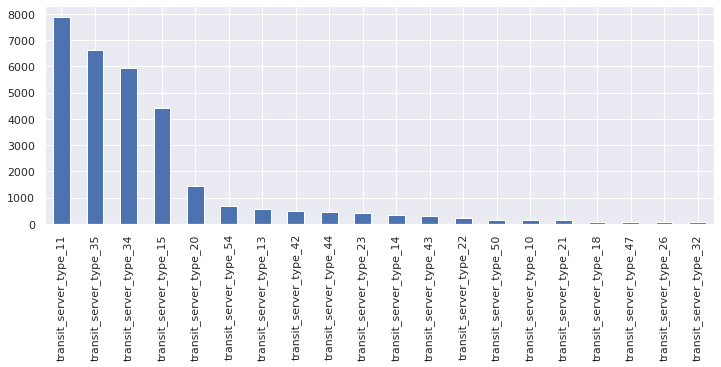

In [148]:
plt.figure(figsize=(12,4))
server_df.transit_server_type.value_counts().nlargest(20).plot(kind='bar')
plt.show()

`Wrangling data for model building`

In [149]:
server_df = server_df.pivot_table(values='transit_server_type',index='id',columns='transit_server_type',fill_value=0,aggfunc=len)
server_df.head()

transit_server_type,transit_server_type_1,transit_server_type_10,transit_server_type_11,transit_server_type_12,transit_server_type_13,transit_server_type_14,transit_server_type_15,transit_server_type_17,transit_server_type_18,transit_server_type_19,transit_server_type_2,transit_server_type_20,transit_server_type_21,transit_server_type_22,transit_server_type_23,transit_server_type_24,transit_server_type_25,transit_server_type_26,transit_server_type_27,transit_server_type_28,transit_server_type_29,transit_server_type_3,transit_server_type_30,transit_server_type_31,transit_server_type_32,transit_server_type_33,transit_server_type_34,transit_server_type_35,transit_server_type_36,transit_server_type_37,transit_server_type_38,transit_server_type_39,transit_server_type_4,transit_server_type_40,transit_server_type_41,transit_server_type_42,transit_server_type_43,transit_server_type_44,transit_server_type_45,transit_server_type_46,transit_server_type_47,transit_server_type_48,transit_server_type_49,transit_server_type_5,transit_server_type_50,transit_server_type_51,transit_server_type_52,transit_server_type_53,transit_server_type_54,transit_server_type_6,transit_server_type_7,transit_server_type_8,transit_server_type_9
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [150]:
server_df.columns = server_df.columns.categories
server_df.head()

,transit_server_type_1,transit_server_type_10,transit_server_type_11,transit_server_type_12,transit_server_type_13,transit_server_type_14,transit_server_type_15,transit_server_type_17,transit_server_type_18,transit_server_type_19,transit_server_type_2,transit_server_type_20,transit_server_type_21,transit_server_type_22,transit_server_type_23,transit_server_type_24,transit_server_type_25,transit_server_type_26,transit_server_type_27,transit_server_type_28,transit_server_type_29,transit_server_type_3,transit_server_type_30,transit_server_type_31,transit_server_type_32,transit_server_type_33,transit_server_type_34,transit_server_type_35,transit_server_type_36,transit_server_type_37,transit_server_type_38,transit_server_type_39,transit_server_type_4,transit_server_type_40,transit_server_type_41,transit_server_type_42,transit_server_type_43,transit_server_type_44,transit_server_type_45,transit_server_type_46,transit_server_type_47,transit_server_type_48,transit_server_type_49,transit_server_type_5,transit_server_type_50,transit_server_type_51,transit_server_type_52,transit_server_type_53,transit_server_type_54,transit_server_type_6,transit_server_type_7,transit_server_type_8,transit_server_type_9
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [151]:
server_df= server_df.reset_index()
server_df.head()

,id,transit_server_type_1,transit_server_type_10,transit_server_type_11,transit_server_type_12,transit_server_type_13,transit_server_type_14,transit_server_type_15,transit_server_type_17,transit_server_type_18,transit_server_type_19,transit_server_type_2,transit_server_type_20,transit_server_type_21,transit_server_type_22,transit_server_type_23,transit_server_type_24,transit_server_type_25,transit_server_type_26,transit_server_type_27,transit_server_type_28,transit_server_type_29,transit_server_type_3,transit_server_type_30,transit_server_type_31,transit_server_type_32,transit_server_type_33,transit_server_type_34,transit_server_type_35,transit_server_type_36,transit_server_type_37,transit_server_type_38,transit_server_type_39,transit_server_type_4,transit_server_type_40,transit_server_type_41,transit_server_type_42,transit_server_type_43,transit_server_type_44,transit_server_type_45,transit_server_type_46,transit_server_type_47,transit_server_type_48,transit_server_type_49,transit_server_type_5,transit_server_type_50,transit_server_type_51,transit_server_type_52,transit_server_type_53,transit_server_type_54,transit_server_type_6,transit_server_type_7,transit_server_type_8,transit_server_type_9
0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [152]:
# checking for any nulls
server_df.isnull().values.any()

False

In [153]:
# shape of the dataset post processing
server_df.shape

(18552, 54)

#### 3.5 Train Data

In [154]:
train_df.head()

,id,area_code,outage_duration
0,13366,area_415,1
1,6783,area_474,0
2,9519,area_931,1
3,10202,area_700,1
4,4555,area_600,2


In [155]:
# Shape of the train data before processing
train_df.shape

(5904, 3)

In [156]:
# Summary of the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5904 entries, 0 to 5903
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5904 non-null   int64 
 1   area_code        5904 non-null   object
 2   outage_duration  5904 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 138.5+ KB


In [157]:
# Changing the type of the data
train_df = train_df.astype('category')

In [158]:
# Summary post change of the type
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5904 entries, 0 to 5903
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               5904 non-null   category
 1   area_code        5904 non-null   category
 2   outage_duration  5904 non-null   category
dtypes: category(3)
memory usage: 282.0 KB


In [159]:
# data description
train_df.describe()

,id,area_code,outage_duration
count,5904,5904,5904
unique,5904,876,3
top,18550,area_821,0
freq,1,67,3827


From the description above we can infer that,
1. Each row has a unique `id` and there are a total of `5904` ids
2. There are a total `876` `aread_codes`
3. `area_821` is the most frequently occuring with the frequency of `67`

**Lets understand the distribution of the outage_duration with help of a pie-chart**

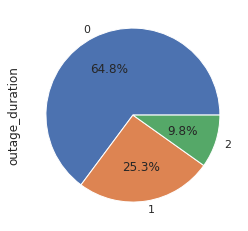

In [160]:
train_df.outage_duration.value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.show()

There is clear class imbalance in the train data

## 4. Answers to the operations team

#### 4.1 Which areas are most prone to long outage durations?

In [161]:
# Filtering the area with outage duration is long, and getting the count of occurence
long_outage_area_count = train_df.loc[train_df.outage_duration==2].area_code.value_counts()

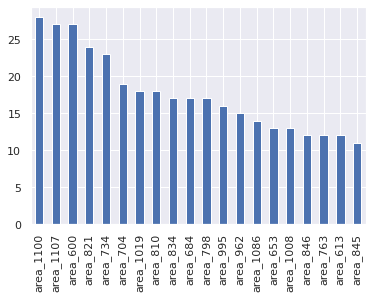

In [162]:
# Plotting top 20 areas most prone to long outage duration
long_outage_area_count.nlargest(20).plot(kind='bar')
plt.show()

In [163]:
# Getting the names of all the areas with outage_duration long in a list in decreasing order
long_outage_areas = list(long_outage_area_count[long_outage_area_count>0].index)

In [164]:
# printing the above list
print(long_outage_areas)

['area_1100', 'area_1107', 'area_600', 'area_821', 'area_734', 'area_704', 'area_1019', 'area_810', 'area_834', 'area_684', 'area_798', 'area_995', 'area_962', 'area_1086', 'area_653', 'area_1008', 'area_846', 'area_763', 'area_613', 'area_845', 'area_638', 'area_1042', 'area_1052', 'area_895', 'area_1075', 'area_976', 'area_1061', 'area_921', 'area_599', 'area_892', 'area_745', 'area_984', 'area_931', 'area_866', 'area_830', 'area_779', 'area_641', 'area_644', 'area_906', 'area_885', 'area_909', 'area_884', 'area_1051', 'area_897', 'area_769', 'area_1089', 'area_864', 'area_844', 'area_13', 'area_744', 'area_726', 'area_705', 'area_7', 'area_619', 'area_674', 'area_667', 'area_646', 'area_648', 'area_1050', 'area_1', 'area_1020', 'area_925', 'area_926', 'area_1046', 'area_991', 'area_1024', 'area_839', 'area_724', 'area_1016', 'area_73', 'area_924', 'area_655', 'area_840', 'area_1109', 'area_1111', 'area_826', 'area_1103', 'area_601', 'area_1026', 'area_972', 'area_1017', 'area_774', 

#### 4.2 Which broadband types are suspect of long outage durations?

In [165]:
# Filtering long outage_duration, merging the train_data with broadband_df, getting the sum along axis=0 , sorting in descending
broadband_types_long_outage = train_df.loc[train_df.outage_duration==2][['id']]\
                                .merge(broadband_df,on='id').sum().drop(index='id')\
                                    .sort_values(ascending=False)
print(broadband_types_long_outage)

ADSL 1              544
ADSL 2               82
ADSL 2+              26
Fiber 1              17
Fiber Ultra          10
Cable                 9
Fiber 2               4
BPL                   4
Fiber Ultra Max       3
Fiber High Speed      1
dtype: int64


As we can see the long outage duration has ADSL 1 as the most common type of broadband followed by other ADSL types. Lets visualize the same in a bar chart

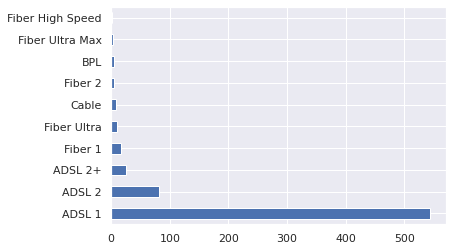

In [166]:
broadband_types_long_outage.plot(kind='barh')
plt.show()

#### 4.3 Any other recommendations to improve the detection of outage durations.
1. As we saw some of the datasets had predictor variables of categorical type which huge number of categories, we can group data and reduce them, to improve our detection of outage durations
2. From the pie chart we saw that the training data has some class imbalance, hence using techniques like smoting etc. can improve the detection of the outage duration

## 5. Model Building

Lets try building the model starting least complex to most complex with validation and comparing the performance of each model

In [167]:
# test data set
test_df = pd.read_csv('data/test_data-1593798292529.csv')
test_df.head()

,id,area_code
0,3340,area_344
1,14067,area_933
2,1134,area_16
3,27,area_793
4,9793,area_344


In [168]:
test_df.area_code = test_df.area_code.astype('category')

### 5.1 Pre-Processing

#### 5.1.1 Merging datasets and splitting data into input and output(X and y)

In [169]:
# merging train data with the other dataframes

train_dfs = [train_df,broadband_df,outage_df,report_df,server_df]
test_dfs = [test_df,broadband_df,outage_df,report_df,server_df]
train_final = reduce(lambda left,right: pd.merge(left,right,on='id'), train_dfs)
test_final =  reduce(lambda left,right: pd.merge(left,right,on='id'), test_dfs)

In [170]:
train_final.shape,test_final.shape

((5904, 457), (1477, 456))

In [171]:
train_final.set_index('id',inplace=True)
X_train, X_val, y_train, y_val = train_test_split(train_final.drop('outage_duration',axis=1), train_df.outage_duration, test_size=0.2, random_state=42)

X_test = test_final.set_index('id')


In [172]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape

((4723, 455), (4723,), (1181, 455), (1181,), (1477, 455))

Hence our final train data has 5904 rows which is what we started with and has 455 predictor variables and test data has 1477 observations

#### 5.1.2 Pipeling of pre-processing

In [173]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [174]:
num_attr = list(X_train.select_dtypes('number').columns)
cat_attr = list(X_train.select_dtypes('category').columns)

In [175]:
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore',))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

### 5.2 Neural Network - 1

In [176]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim

In [177]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1330, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)
        self.fc7 = nn.Linear(10, 3)

        self.dropout = nn.Dropout(p=0.4)

        
    def forward(self, x):
        # make sure input tensor is flattened        
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.dropout(F.leaky_relu(self.fc3(x)))
        x = self.dropout(F.leaky_relu(self.fc4(x)))
        x = self.dropout(F.leaky_relu(self.fc5(x)))
        x = self.dropout(F.leaky_relu(self.fc6(x)))
        x = F.log_softmax(self.fc7(x), dim=1)
        
        return x

In [178]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [179]:
model = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [180]:
model

Classifier(
  (fc1): Linear(in_features=1330, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=10, bias=True)
  (fc7): Linear(in_features=10, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [181]:
X_train_np = preprocessor.fit_transform(train_final.drop('outage_duration',axis=1))

In [182]:
X_train_tensor = torch.from_numpy(X_train_np).float().to(device)
y_train_tensor =  torch.Tensor(train_final.outage_duration.values).long().to(device)

In [183]:
epochs = 10000
for i in range(epochs):
    log_ps = model(X_train_tensor)
    loss = criterion(log_ps, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Training loss: {loss.item()}")

Streaming output truncated to the last 5000 lines.
Training loss: 0.09529862552881241
Training loss: 0.09639932215213776
Training loss: 0.09903501719236374
Training loss: 0.10958708077669144
Training loss: 0.09818337857723236
Training loss: 0.09385041147470474
Training loss: 0.09996059536933899
Training loss: 0.10471389442682266
Training loss: 0.10062582790851593
Training loss: 0.1040707603096962
Training loss: 0.09562818706035614
Training loss: 0.09487742185592651
Training loss: 0.09802520275115967
Training loss: 0.09475748240947723
Training loss: 0.10438619554042816
Training loss: 0.09597305953502655
Training loss: 0.10294214636087418
Training loss: 0.10204189270734787
Training loss: 0.1119057685136795
Training loss: 0.10148140788078308
Training loss: 0.1013086587190628
Training loss: 0.09794578701257706
Training loss: 0.09896228462457657
Training loss: 0.1002935990691185
Training loss: 0.10168478637933731
Training loss: 0.09483490139245987
Training loss: 0.10115958005189896
Training

In [184]:
y_pred = model(X_train_tensor)

In [185]:
y_pred = torch.argmax(y_pred,axis=1)

In [186]:
y_train_tensor

tensor([1, 0, 1,  ..., 2, 0, 0], device='cuda:0')

In [187]:
from sklearn.metrics import accuracy_score

In [188]:
accuracy_score(np.array(y_train_tensor.to('cpu')),np.array( y_pred.to('cpu')))

0.9696815718157181

In [189]:
X_test_np = preprocessor.transform(test_final)

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [190]:
X_test_tensor = torch.from_numpy(X_test_np).float().to(device)

In [191]:
y_pred = torch.argmax(model(X_test_tensor),axis=1)
y_pred = y_pred.to('cpu').numpy()


In [192]:
output_nn = pd.DataFrame({'id':test_df.id.values,'outage_duration':y_pred})

### 5.3 Neural Network - 2

In [197]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1330, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, 128)
        self.fc8 = nn.Linear(128, 128)
        self.fc9 = nn.Linear(128, 50)
        self.fc10 = nn.Linear(50, 10)
        self.fc11 = nn.Linear(10, 3)

        self.dropout = nn.Dropout(p=0.4)

        
    def forward(self, x):
        # make sure input tensor is flattened        
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.dropout(F.leaky_relu(self.fc3(x)))
        x = self.dropout(F.leaky_relu(self.fc4(x)))
        x = self.dropout(F.leaky_relu(self.fc5(x)))
        x = self.dropout(F.leaky_relu(self.fc6(x)))
        x = self.dropout(F.leaky_relu(self.fc7(x)))
        x = self.dropout(F.leaky_relu(self.fc8(x)))
        x = self.dropout(F.leaky_relu(self.fc9(x)))
        x = self.dropout(F.leaky_relu(self.fc10(x)))
        x = F.log_softmax(self.fc7(x), dim=1)
        
        return x

In [198]:
model = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [201]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, TensorDataset

def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    dataset = TensorDataset( X_train_tensor, y_train_tensor )

    # obtain training indices that will be used for validation
    num_train = len(train_final)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    return train_loader,  valid_loader


In [1]:
from pytorchtools import EarlyStopping

def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

ModuleNotFoundError: No module named 'torch'

In [ ]:
!pip install torch

In [ ]:
X_train_tensor = torch.from_numpy(X_train_np).float().to(device)
y_train_tensor =  torch.Tensor(train_final.outage_duration.values).long().to(device)

In [ ]:
epochs = 10000
for i in range(epochs):
    log_ps = model(X_train_tensor)
    loss = criterion(log_ps, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Training loss: {loss.item()}")

Streaming output truncated to the last 5000 lines.
Training loss: 0.1354953646659851
Training loss: 0.14191880822181702
Training loss: 0.1379302740097046
Training loss: 0.1288977414369583
Training loss: 0.13673637807369232
Training loss: 0.13814379274845123
Training loss: 0.13252395391464233
Training loss: 0.13412542641162872
Training loss: 0.1537761241197586
Training loss: 0.13998520374298096
Training loss: 0.13475528359413147
Training loss: 0.14020457863807678
Training loss: 0.13688607513904572
Training loss: 0.14135347306728363
Training loss: 0.1372460573911667
Training loss: 0.13814012706279755
Training loss: 0.1364450603723526
Training loss: 0.14482347667217255
Training loss: 0.1350596398115158
Training loss: 0.13199393451213837
Training loss: 0.1300664097070694
Training loss: 0.13455703854560852
Training loss: 0.14048106968402863
Training loss: 0.12928713858127594
Training loss: 0.13232630491256714
Training loss: 0.13475997745990753
Training loss: 0.13141265511512756
Training los

In [ ]:
y_pred = model(X_train_tensor)

In [ ]:
y_pred = torch.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(np.array(y_train_tensor.to('cpu')),np.array( y_pred.to('cpu')))

0.9637533875338753

In [ ]:
X_test_np = preprocessor.transform(test_final)

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1330, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)
        self.fc7 = nn.Linear(10, 3)

        self.dropout = nn.Dropout(p=0.4)

        
    def forward(self, x):
        # make sure input tensor is flattened        
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.dropout(F.leaky_relu(self.fc3(x)))
        x = self.dropout(F.leaky_relu(self.fc4(x)))
        x = self.dropout(F.leaky_relu(self.fc5(x)))
        x = self.dropout(F.leaky_relu(self.fc6(x)))
        x = F.log_softmax(self.fc7(x), dim=1)
        
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
X_train_np = preprocessor.fit_transform(train_final.drop('outage_duration',axis=1))

In [ ]:
X_train_tensor = torch.from_numpy(X_train_np).float().to(device)
y_train_tensor =  torch.Tensor(train_final.outage_duration.values).long().to(device)

In [ ]:
epochs = 10000
for i in range(epochs):
    log_ps = model(X_train_tensor)
    loss = criterion(log_ps, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Training loss: {loss.item()}")

Streaming output truncated to the last 5000 lines.
Training loss: 0.1354953646659851
Training loss: 0.14191880822181702
Training loss: 0.1379302740097046
Training loss: 0.1288977414369583
Training loss: 0.13673637807369232
Training loss: 0.13814379274845123
Training loss: 0.13252395391464233
Training loss: 0.13412542641162872
Training loss: 0.1537761241197586
Training loss: 0.13998520374298096
Training loss: 0.13475528359413147
Training loss: 0.14020457863807678
Training loss: 0.13688607513904572
Training loss: 0.14135347306728363
Training loss: 0.1372460573911667
Training loss: 0.13814012706279755
Training loss: 0.1364450603723526
Training loss: 0.14482347667217255
Training loss: 0.1350596398115158
Training loss: 0.13199393451213837
Training loss: 0.1300664097070694
Training loss: 0.13455703854560852
Training loss: 0.14048106968402863
Training loss: 0.12928713858127594
Training loss: 0.13232630491256714
Training loss: 0.13475997745990753
Training loss: 0.13141265511512756
Training los

In [ ]:
y_pred = model(X_train_tensor)

In [ ]:
y_pred = torch.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(np.array(y_train_tensor.to('cpu')),np.array( y_pred.to('cpu')))

0.9637533875338753

In [ ]:
X_test_np = preprocessor.transform(test_final)

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


### 5.2 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [ ]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=10000, tol=0.1))])

In [ ]:
clf_logreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['ADSL 1', 'ADSL 2',
                                                   'ADSL 2+', 'BPL', 'Cable',
                                        

In [ ]:
print(clf_logreg.score(X_train, y_train),clf_logreg.score(X_val,y_val))

0.7982214694050391 0.7019475021168501


In [ ]:
y_test_log_reg = clf_logreg.predict(X_test)

In [ ]:
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_log_reg})
output.to_csv('logistic/output1.csv',index=False)

The above classification resulted in 57% accuracy in the case of test data

**Class imbalance as a problem suspected, hence going for smote**

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
# smote in pipeline
sm = SMOTE(sampling_strategy='minority', random_state=7)
smote_logreg = Pipeline(steps=[('preprocessor', preprocessor),('sampling',sm),
                      ('classifier', LogisticRegression(max_iter=10000, tol=0.1))])

In [ ]:
smote_logreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['ADSL 1', 'ADSL 2',
                                                   'ADSL 2+', 'BPL', 'Cable',
                                        

In [ ]:
print(smote_logreg.score(X_train, y_train),smote_logreg.score(X_val,y_val))

0.7641329663349566 0.6655376799322608


In [ ]:
y_test_logistic_smote = smote_logreg.predict(X_test)

In [ ]:
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_logistic_smote})
output.to_csv('logistic/output2.csv',index=False)

Smote resulted in performance decrease, and the test result was 53%, hence smote was a bad idea. let's try PCA

**PCA**

In [ ]:
pca = PCA()
pca_log_pipe = Pipeline(steps=[('preprocessor', preprocessor),('pca', pca),
                      ('classifier', LogisticRegression(max_iter=10000, tol=0.1))])
param_grid = {
    'pca__n_components': [10, 50, 100, 200, 500]
}

pca_logistic_grid = GridSearchCV(pca_log_pipe, param_grid, n_jobs=-1,verbose=10)
pca_logistic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:   18.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   23.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          MinMaxScaler(copy=True,
                                                                                                       feature_range=(0,
                                       

In [ ]:
print(pca_logistic_grid.score(X_train, y_train),pca_logistic_grid.score(X_val,y_val))

0.7654033453313572 0.7061812023708721


In [ ]:
y_test_logistic_pca = pca_logistic_grid.predict(X_test)

In [ ]:
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_logistic_pca})
output.to_csv('logistic/output3.csv',index=False)

PCA with 500 parameters resulted in a higher test accuracy of 58%, trying with further small principal components as 100

In [ ]:
#with PCA 100
logistic_pca = Pipeline(steps=[('preprocessor', preprocessor),('pca',PCA(n_components=100)),
                      ('classifier', LogisticRegression(max_iter=10000, tol=0.1))])

In [ ]:
logistic_pca.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['ADSL 1', 'ADSL 2',
                                                   'ADSL 2+', 'BPL', 'Cable',
                                        

In [ ]:
print(logistic_pca.score(X_train, y_train),logistic_pca.score(X_val,y_val))

0.7082362904933305 0.6934801016088061


In [ ]:
y_test_logistic_pca2 = logistic_pca.predict(X_test)

In [ ]:
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_logistic_pca2})
output.to_csv('logistic/output4.csv',index=False)

In [ ]:
#with PCA 800
logistic_pca1 = Pipeline(steps=[('preprocessor', preprocessor),('pca',PCA(n_components=800)),
                      ('classifier', LogisticRegression(max_iter=10000, tol=0.1))])

In [ ]:
logistic_pca1.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['ADSL 1', 'ADSL 2',
                                                   'ADSL 2+', 'BPL', 'Cable',
                                        

In [ ]:
print(logistic_pca1.score(X_train, y_train),logistic_pca1.score(X_val,y_val))

0.7903874655939022 0.6968670618120237


In [ ]:
y_test_logistic_pca3 = logistic_pca.predict(X_test)
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_logistic_pca3})
output.to_csv('logistic/output5.csv',index=False)

In [ ]:
train_vol_dfs = [train_df,broadband_df,outage_df,report_volume_df]
test_vol_dfs = [test_df,broadband_df,outage_df,report_volume_df]
train_vol_final = reduce(lambda left,right: pd.merge(left,right,on='id'), train_vol_dfs)
test_vol_final =  reduce(lambda left,right: pd.merge(left,right,on='id'), test_vol_dfs)

In [ ]:
train_vol_final = train_vol_final.set_index('id')
X_train_vol, X_val_vol, y_train_vol, y_val_vol = train_test_split(train_vol_final.drop('outage_duration',axis=1), train_vol_final.outage_duration, test_size=0.2,stratify=train_df.outage_duration, random_state=42)

X_test_vol = test_vol_final.set_index('id')

In [ ]:
X_train_vol.shape, X_val_vol.shape, y_train_vol.shape, y_val_vol.shape, X_test_vol.shape

((4723, 17), (1181, 17), (4723,), (1181,), (1477, 17))

In [ ]:
X_train_vol.columns

Index(['area_code', 'ADSL 1', 'ADSL 2', 'ADSL 2+', 'BPL', 'Cable', 'Fiber 1',
       'Fiber 2', 'Fiber High Speed', 'Fiber Ultra', 'Fiber Ultra Max',
       'outage_type_1', 'outage_type_2', 'outage_type_3', 'outage_type_4',
       'outage_type_5', 'volume'],
      dtype='object')

In [ ]:
X_train_vol.columns

Index(['area_code', 'ADSL 1', 'ADSL 2', 'ADSL 2+', 'BPL', 'Cable', 'Fiber 1',
       'Fiber 2', 'Fiber High Speed', 'Fiber Ultra', 'Fiber Ultra Max',
       'outage_type_1', 'outage_type_2', 'outage_type_3', 'outage_type_4',
       'outage_type_5', 'volume'],
      dtype='object')

In [ ]:
clf_logreg.fit(X_train_vol,y_train_vol)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['ADSL 1', 'ADSL 2',
                                                   'ADSL 2+', 'BPL', 'Cable',
                                        

In [ ]:
print(clf_logreg.score(X_train_vol,y_train_vol),clf_logreg.score(X_val_vol,y_val_vol))

0.747194579716282 0.668077900084674


In [ ]:
y_test_logistic_vol = clf_logreg.predict(X_test_vol)
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_logistic_vol})
output.to_csv('logistic/output5.csv',index=False)

### 5.3 KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_pipe = Pipeline(steps=[('preprocessor', preprocessor),('pca',PCA(500)),
                      ('classifier', KNeighborsClassifier())])

In [ ]:
knn_pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['ADSL 1', 'ADSL 2',
                                                   'ADSL 2+', 'BPL', 'Cable',
                                        

In [ ]:
print(knn_pipe.score(X_train,y_train),knn_pipe.score(X_val,y_val))

0.7899640059284353 0.6850127011007621


In [ ]:
y_test_knn = knn_pipe.predict(X_test)
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_knn})
output.to_csv('knn/output1.csv',index=False)

Even the above case resulted in a 58% accuracy, but knn suffers from curse of dimensionality

### 5.3 SVM classifier

In [ ]:
from sklearn.svm import SVC 

In [ ]:
svm_basic = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])

In [ ]:
svm_basic.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['ADSL 1', 'ADSL 2',
                                                   'ADSL 2+', 'BPL', 'Cable',
                                        

In [ ]:
print(svm_basic.score(X_train,y_train),svm_basic.score(X_val,y_val))

0.7709083209824265 0.6985605419136325


**Trying out grid search with different hyperparameters**

In [ ]:
param_grid = {'classifier__C': [0.1, 1, 10, 100, 1000],  
              'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'classifier__kernel': ['poly', 'rbf', 'sigmoid','linear']}

In [ ]:
svm_grid = GridSearchCV(svm_basic, param_grid=param_grid, n_jobs=-1, verbose=10)

In [ ]:
svm_grid.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 24

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          MinMaxScaler(copy=True,
                                                                                                       feature_range=(0,
                                       

In [ ]:
svm_grid.best_params_

{'classifier__C': 1, 'classifier__gamma': 1, 'classifier__kernel': 'poly'}

In [ ]:
print(svm_grid.score(X_train,y_train),svm_grid.score(X_val,y_val))

0.8827016726656786 0.7002540220152413


In [ ]:
y_test_svm = svm_grid.predict(X_test)
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_svm})
output.to_csv('svm/output1.csv',index=False)

Above output resulted in a 59% percent accuracy which is improvement

**Using bagging classifier over SVM to see if there is any improvement in performance**

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
svm_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='poly',gamma=1))])

In [ ]:
svm_bagged = BaggingClassifier(svm_basic, n_estimators=80, random_state=314,n_jobs=-1)

In [ ]:
X = pd.DataFrame(preprocessor.fit_transform(X_train))
Xv =pd.DataFrame(preprocessor.transform(X_val))

In [ ]:
svm=BaggingClassifier(SVC(kernel='poly',gamma=1), max_samples=0.4,max_features=0.5, n_estimators=80, n_jobs=-1,random_state=123,verbose=10)

In [ ]:
svm.fit(X,y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   51.8s remaining:   51.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   52.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   52.5s finished


BaggingClassifier(base_estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                     class_weight=None, coef0=0.0,
                                     decision_function_shape='ovr', degree=3,
                                     gamma=1, kernel='poly', max_iter=-1,
                                     probability=False, random_state=None,
                                     shrinking=True, tol=0.001, verbose=False),
                  bootstrap=True, bootstrap_features=False, max_features=0.5,
                  max_samples=0.4, n_estimators=80, n_jobs=-1, oob_score=False,
                  random_state=123, verbose=10, warm_start=False)

In [ ]:
print(svm.score(X,y_train),svm.score(Xv,y_val))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   26.9s remaining:   26.9s


0.7313148422612746 0.6900931414055885


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   29.3s finished


In [ ]:
Xt = pd.DataFrame(preprocessor.transform(X_test))
y_test_svm_bag = svm.predict(Xt)
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_svm_bag})
output.to_csv('svm/output2.csv',index=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   36.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.7s remaining:   36.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   38.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   38.8s finished


50% on test

### 5.4 Tree Based Methods

* Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(oob_score=True,n_jobs=-1)
rfc_pipe = Pipeline(steps=[('pre',preprocessor),('rf',rfc)])

In [ ]:
param_grid = {'rf__n_estimators': [200, 400, 1000, 1400, 2000],'rf__bootstrap': [True, False],'rf__criterion':['gini','entropy'],'rf__min_samples_leaf': [1, 2, 4,10,20],
 'rf__min_samples_split': [2, 5, 10],'rf__max_features':['sqrt','log2']}

In [ ]:
forest_grid = GridSearchCV(rfc_pipe,param_grid,verbose=10,n_jobs=-1)

In [ ]:
forest_grid.fit(X_train,y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 41.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 45

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          MinMaxScaler(copy=True,
                                                                                                       feature_range=(0,
                                                

In [ ]:
forest_grid.best_estimator_

Pipeline(memory=None,
         steps=[('pre',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['ADSL 1', 'ADSL 2',
                                                   'ADSL 2+', 'BPL', 'Cable',
                                                 

In [ ]:
forest_grid.score(X_train,y_train),forest_grid.score(X_val,y_val)

(0.9697226339191192, 0.7552921253175275)

In [ ]:
y_test_rf = forest_grid.predict(X_test)
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_rf})
output.to_csv('randomforest/output1.csv',index=False)

The random forest resulted in an accuracy of 65%. There seems to be an overfit! Lets tune the parameters by pruning and avoid the overfitting

**Tuned Random Forest Classifier**

In [ ]:
param_grid = {'rf__n_estimators': [800,1200,2000],'rf__bootstrap': [True],'rf__criterion':['entropy'],
 'rf__max_depth': [2,4,6,8,10,15,20],'rf__max_features':['sqrt']}

In [ ]:
forest_grid2 = GridSearchCV(rfc_pipe,param_grid,verbose=10,n_jobs=-1)

In [ ]:
forest_grid2.fit(X_train,y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 20.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          MinMaxScaler(copy=True,
                                                                                                       feature_range=(0,
                                                

In [ ]:
forest_grid2.best_params_

{'rf__bootstrap': True,
 'rf__criterion': 'entropy',
 'rf__max_depth': 20,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 2000}

In [ ]:
forest_grid2.score(X_train,y_train),forest_grid2.score(X_val,y_val)

(0.8384501376243912, 0.7349703640982218)

In [ ]:
y_test_rf2 = forest_grid2.predict(X_test)
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_rf2})
output.to_csv('randomforest/output2.csv',index=False)

The above model resulted in a 62%

In [ ]:
rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=-1,
                                        oob_score=True, random_state=None,
                                        verbose=0, warm_start=False)

In [ ]:
rf_final_pipe = Pipeline(steps=[('pre',preprocessor),('rf',rf_final)])

In [ ]:
rf_final_pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('pre',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['ADSL 1', 'ADSL 2',
                                                   'ADSL 2+', 'BPL', 'Cable',
                                                 

In [ ]:
rf_final_pipe.score(X_train,y_train),rf_final_pipe.score(X_val,y_val)

(0.9720516620791869, 0.7552921253175275)

In [ ]:
y_test_final = rf_final_pipe.predict(X_test)
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_final})
output.to_csv('randomforest/output3.csv',index=False)

Again the result was 65%, hence proceeding with boosting models

#### 5.4.2 Boosting

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.2,  
                      colsample_bytree = 0.4,
                      subsample = 0.5,
                      objective='multi:softprob', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=0.5,
                     num_class = 3)

In [ ]:
model = XGBClassifier(learning_rate=0.25,colsample_bytree = 0.5,subsample = 0.9,n_estimators=1000,objective='multi:softprob',n_jobs=-1,verbosity=1)

In [ ]:
eval_set = [(preprocessor.transform(X_val), y_val)]
model = model.fit((preprocessor.transform(X_train)),y_train,eval_set=eval_set,early_stopping_rounds=200,verbose=True)

[0]	validation_0-merror:0.30906
Will train until validation_0-merror hasn't improved in 200 rounds.
[1]	validation_0-merror:0.27180
[2]	validation_0-merror:0.27180
[3]	validation_0-merror:0.27180
[4]	validation_0-merror:0.27011
[5]	validation_0-merror:0.26926
[6]	validation_0-merror:0.26842
[7]	validation_0-merror:0.26926
[8]	validation_0-merror:0.26757
[9]	validation_0-merror:0.26672
[10]	validation_0-merror:0.26334
[11]	validation_0-merror:0.26418
[12]	validation_0-merror:0.26249
[13]	validation_0-merror:0.26418
[14]	validation_0-merror:0.25910
[15]	validation_0-merror:0.25826
[16]	validation_0-merror:0.25826
[17]	validation_0-merror:0.25656
[18]	validation_0-merror:0.25656
[19]	validation_0-merror:0.25741
[20]	validation_0-merror:0.25741
[21]	validation_0-merror:0.25572
[22]	validation_0-merror:0.25572
[23]	validation_0-merror:0.25656
[24]	validation_0-merror:0.25572
[25]	validation_0-merror:0.25402
[26]	validation_0-merror:0.25233
[27]	validation_0-merror:0.25148
[28]	validation_0-

[243]	validation_0-merror:0.24217
[244]	validation_0-merror:0.24217
[245]	validation_0-merror:0.24217
[246]	validation_0-merror:0.24047
[247]	validation_0-merror:0.24132
[248]	validation_0-merror:0.24132
[249]	validation_0-merror:0.24132
[250]	validation_0-merror:0.24047
[251]	validation_0-merror:0.24047
[252]	validation_0-merror:0.24047
[253]	validation_0-merror:0.24047
[254]	validation_0-merror:0.23878
[255]	validation_0-merror:0.24132
[256]	validation_0-merror:0.24132
[257]	validation_0-merror:0.24132
[258]	validation_0-merror:0.24047
[259]	validation_0-merror:0.24132
[260]	validation_0-merror:0.24132
[261]	validation_0-merror:0.24132
[262]	validation_0-merror:0.24217
[263]	validation_0-merror:0.24132
[264]	validation_0-merror:0.24047
[265]	validation_0-merror:0.23963
[266]	validation_0-merror:0.23963
[267]	validation_0-merror:0.23963
[268]	validation_0-merror:0.23878
[269]	validation_0-merror:0.23793
[270]	validation_0-merror:0.23793
[271]	validation_0-merror:0.23878
[272]	validati

[484]	validation_0-merror:0.24301
[485]	validation_0-merror:0.24217
[486]	validation_0-merror:0.24132
[487]	validation_0-merror:0.24217
[488]	validation_0-merror:0.24301
[489]	validation_0-merror:0.24132
[490]	validation_0-merror:0.24301
[491]	validation_0-merror:0.24386
[492]	validation_0-merror:0.24301
[493]	validation_0-merror:0.24301
[494]	validation_0-merror:0.24301
[495]	validation_0-merror:0.24386
[496]	validation_0-merror:0.24386
[497]	validation_0-merror:0.24471
[498]	validation_0-merror:0.24386
[499]	validation_0-merror:0.24555
[500]	validation_0-merror:0.24725
Stopping. Best iteration:
[300]	validation_0-merror:0.23455



In [ ]:
model.score(preprocessor.transform(X_train),y_train),model.score(preprocessor.transform(X_val),y_val)

(0.9057802244336227, 0.7654530059271804)

In [ ]:
y_test_xgb = model.predict(preprocessor.transform(X_test))
output = pd.DataFrame({'id':test_df.id,'outage_duration':y_test_xgb})
output.to_csv('xgb/output1.csv',index=False)

The above model gave an accuracy of 65% on test, hence proceeding with the neural networks

## 5. Summary

* We described the problem statement
* Imported necessary libraries to perform EDA
* Read all the datasets in the raw format
* Data Wrangling to get the necessary format for EDA and model building
* Explored each dataset with description and EDA
* Answers to the questions by the operations team
* Recommendations to improve the detection of outage durations

## 6. Next Steps

* Splitting the train dataset into train and validation
* Trying models in the order of the increasing complexity
* Analyzing the performance(bias/variance) of different models
* Tweaking the models and analyzing the performance
* Choosing the best model